Iteration 9: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s, episode=400, return=-25.917]


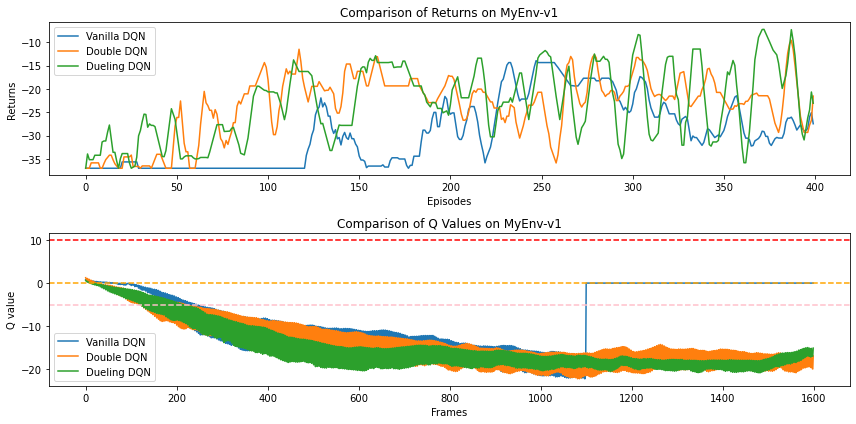

In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import random
import numpy as np

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, value):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if value <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=1e-5):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.tree = SumTree(capacity)
        self.max_priority = 1.0

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        priority = self.max_priority
        self.tree.add(priority, data)

    def sample(self, batch_size):
        batch = []
        indexes = []
        is_weights = []

        segment = self.tree.tree[0] / batch_size

        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            value = random.uniform(a, b)
            index, priority, data = self.tree.get_leaf(value)
            is_weight = np.power(self.tree.tree[index] / self.tree.tree[0], -self.beta)
            is_weights.append(is_weight)
            indexes.append(index)
            batch.append(data)

        sampling_probabilities = np.array(is_weights) / self.tree.tree[0]
        is_weights = np.power(self.tree.tree[indexes] / self.tree.tree[0], -self.beta)
        is_weights /= is_weights.max()
        

        return batch, indexes, is_weights

    def update_priorities(self, index, td_error):
        priority = np.abs(td_error) + 1e-6  # 添加一个小常数以避免零优先级
        priority = min(priority, self.max_priority)
        self.max_priority = max(self.max_priority, priority)
        self.tree.update(index, priority)

    def size(self):
        return self.tree.data_pointer



class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分  #共享网络部分的线性层
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


# 构造网络，训练网络和目标网络共用该结构
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)


#模型构建
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,target_update,device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size)
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state): #计算给定状态的最大Q值
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            ## .max(1)输出tuple每个特征的最大state_value及其索引，[1]获取的每个特征的动作索引shape=[b]
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            # 下个状态的state_value。下一时刻的状态输入到目标网络，得到每个动作对应的奖励，使用训练出来的action索引选取最优动作
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        td_errors = q_targets - q_values
        for i in range(len(transition_dict['dones'])):
            index = transition_dict['indexes'][i]
            self.replay_buffer.update_priorities(index, td_errors[i].item())
        #预测值和目标值的均方误差损失
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        # 梯度清零，保证每个优化步骤都以新的梯度值开始，避免梯度累积的问题
        self.optimizer.zero_grad()
        # 梯度反传
        dqn_loss.backward()
        # 更新训练网络的参数
        self.optimizer.step()
        # 更新目标网络参数
        if self.count % self.target_update == 0: #满足目标网络更新频率target_update，则将q_net的参数复制到target_q_net，以更新目标网络的权重
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


lr = 1e-3
num_episodes =400
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'MyEnv-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 24

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        batch, indexes, is_weights = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': [item[0] for item in batch],
                            'actions': [item[1] for item in batch],
                            'rewards': [item[2] for item in batch],
                            'next_states': [item[3] for item in batch],
                            'dones': [item[4] for item in batch],
                            'indexes': indexes
                        }

                        agent.update(transition_dict)

                        # 计算当前状态的 Q 值并将其添加到 max_q_value_list
                        current_q_value = agent.max_q_value(state)
                        max_q_value_list.append(current_q_value)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
#实例化经验池
replay_buffer = PrioritizedReplayBuffer(buffer_size)

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)
return_list_vanilla, max_q_value_list_vanilla = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

agent1 = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
return_list_double, max_q_value_list_double = train_DQN(agent1, env, num_episodes, replay_buffer, minimal_size, batch_size)

agent2 = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
return_list_dueling, max_q_value_list_dueling = train_DQN(agent2, env, num_episodes, replay_buffer, minimal_size, batch_size)

# 用零填充较短的列表，使它们的长度相等
max_length = max(len(max_q_value_list_vanilla), len(max_q_value_list_double), len(max_q_value_list_dueling))
max_q_value_list_vanilla += [0] * (max_length - len(max_q_value_list_vanilla))
max_q_value_list_double += [0] * (max_length - len(max_q_value_list_double))
max_q_value_list_dueling += [0] * (max_length - len(max_q_value_list_dueling))

# 绘图代码保持不变


# Plot returns
episodes_list = list(range(len(return_list_vanilla)))
mv_return_vanilla = rl_utils.moving_average(return_list_vanilla, 9)
mv_return_double = rl_utils.moving_average(return_list_double, 5)
mv_return_dueling = rl_utils.moving_average(return_list_dueling, 5)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episodes_list, mv_return_vanilla, label='Vanilla DQN')
plt.plot(episodes_list, mv_return_double, label='Double DQN')
plt.plot(episodes_list, mv_return_dueling, label='Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Comparison of Returns on {}'.format(env_name))
plt.legend()

# Plot Q values
frames_list = list(range(len(max_q_value_list_vanilla)))
plt.subplot(2, 1, 2)
plt.plot(frames_list, max_q_value_list_vanilla, label='Vanilla DQN')
plt.plot(frames_list, max_q_value_list_double, label='Double DQN')
plt.plot(frames_list, max_q_value_list_dueling, label='Dueling DQN')
plt.axhline(0, c='orange', ls='--')
plt.axhline(-5, c='pink', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Comparison of Q Values on {}'.format(env_name))
plt.legend()

plt.tight_layout()
plt.show()